# Attempts to reconstruct iSEDfit galaxy photometry
This is all part of an attempt to reliably reconstruct the observed galaxy photometry from SDSS using iSEDfit best-fits. By reconstructing it, I'm learning how to generate Composite Stellar Population spectra and photometry

In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors

In [2]:
# fsps imports 
import fsps
from sedpy.observate import getSED
from sedpy.observate import load_filters

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
# cosmology imports
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
prettyplot()
pretty_colors = prettycolors()

In [5]:
# some constants to help out
lsun = 3.846e33
pc = 3.085677581467e18 # cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.*np.pi * (pc * 10)**2)

### Load in a number of test galaxies with iSEDfit best-fit parameters

In [6]:
# iSEDfit data 
iSEDfit = mrdfits('/Volumes/750GB/hahn/iGalPros/NSA_iSEDfit/nsa_v1_2_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz')

Galaxy 1 : ID = 53999

In [7]:
gal1 = {} 
for key in iSEDfit.__dict__.keys(): 
    gal1[key] = getattr(iSEDfit, key)[53999]

Galaxy 2: ID 18965

In [8]:
gal2 = {} 
for key in iSEDfit.__dict__.keys(): 
    gal2[key] = getattr(iSEDfit, key)[18965]

Galaxy 3: ID 025592

In [9]:
gal3 = {} 
for key in iSEDfit.__dict__.keys(): 
    gal3[key] = getattr(iSEDfit, key)[25592]

SDSS Bands

In [10]:
sdss_bands = fsps.find_filter('sdss')
print sdss_bands
L_sdss = [fsps.get_filter(sdss_band).lambda_eff/1.e4 for sdss_band in ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']]
print L_sdss

['sdss_u', 'sdss_g', 'sdss_i', 'sdss_r', 'sdss_z']
[0.35565, 0.47025, 0.61756, 0.7489899999999999, 0.8946799999999999]


## Observed photometry of test galaxies

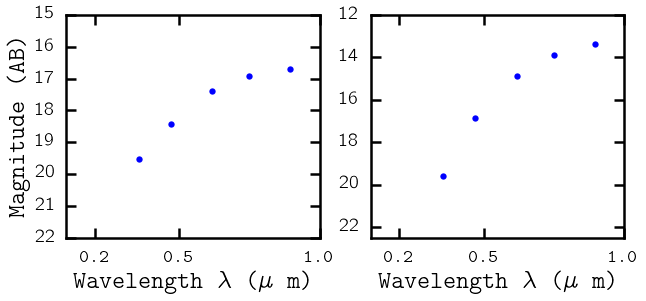

In [11]:
fig = plt.figure(figsize=(10,4))
sub1 = fig.add_subplot(121)
sub1.scatter(L_sdss, -2.5*np.log10(gal1['maggies'][1:-1]), lw=0, s=40)

#sub1.set_xscale('log')
sub1.set_xlim([0.1, 1.])
sub1.set_ylim([22, 15])
#sub1.set_ylim([0., 5.e-7])
sub1.set_xticks([0.2, 0.5, 1.0])
sub1.set_xticklabels([0.2, 0.5, 1.0])
sub1.set_ylabel('Magnitude (AB)', fontsize=25)
sub1.set_xlabel('Wavelength $\lambda$ ($\mu$ m)', fontsize=25)

sub2 = fig.add_subplot(122)
sub2.scatter(L_sdss, -2.5*np.log10(gal2['maggies'][1:-1]), lw=0, s=40)
#sub2.set_xscale('log')
sub2.set_xlim([0.1, 1.])
sub2.set_ylim([22.5, 12])
sub2.set_xticks([0.2, 0.5, 1.0])
sub2.set_xticklabels([0.2, 0.5, 1.0])
sub2.set_xlabel('Wavelength $\lambda$ ($\mu$ m)', fontsize=25)

#bkgd = fig.add_subplot(111, frame_on=False)

# Compare photometry to composite stellar population spectra

In [12]:
pop = fsps.StellarPopulation(zcontinuous=1)

In [13]:
default_params = dict([(k, pop.params[k]) for k in pop.params.all_params])

In [16]:
def GalSpec(gal_dict): 
    # reset parameters
    for k in pop.params.all_params:
        pop.params[k] = default_params[k]
    
    # set parameters
    pop.params['sfh'] = 1
    pop.params['tau'] = gal_dict['tau']
    pop.params['dust_type'] = 2
    pop.params['dust2'] = 0.92 * gal_dict['av'] * gal_dict['mu'] # ln(10) * 0.4 * A(V)
    pop.params['logzsol'] = np.log10(gal_dict['zmetal']/0.019)
   
    wave, space = pop.get_spectrum(tage=gal_dict['age'], peraa=False)
    
    mass = 10**gal_dict['mstar'] / pop.stellar_mass
    spec = mass*space
    
    d_lum = cosmo.luminosity_distance(gal_dict['z']).value
    d_factor = (d_lum * 1e5)**2
    a = (1. + gal_dict['z'])
    
    spec_AB = -2.5 * np.log10(spec * to_cgs * a / d_factor / 1e3 / (3631 * 1e-26)) # AB magnitude
    
    return wave*a, spec_AB*a

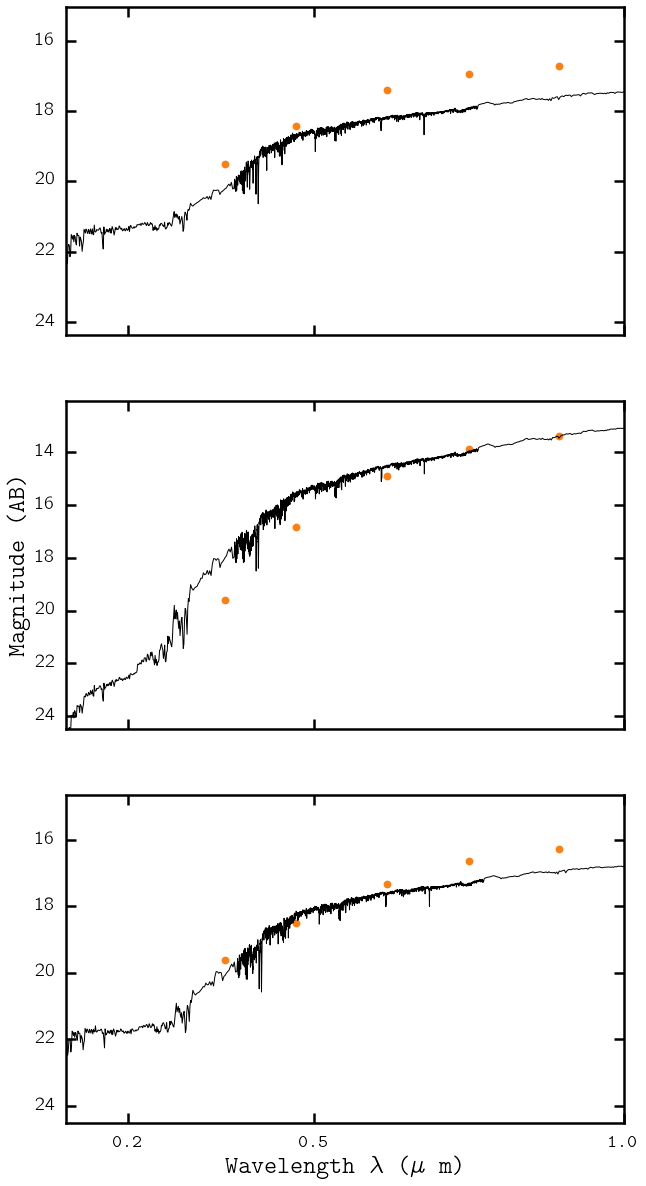

In [17]:
fig = plt.figure(figsize=(10,20))

for i_gal, gal_dict in enumerate([gal1, gal2, gal3]): 
    sub = fig.add_subplot(3,1,i_gal+1)
    
    wave1, spec1 = GalSpec(gal_dict)
    sub.plot(wave1/1.e4, spec1, c='k', lw=1)
    sub.scatter(L_sdss, -2.5*np.log10(gal_dict['maggies'][1:-1]), lw=0, s=60, c=pretty_colors[3])

    sub.set_xlim([0.1, 1.])
    sub.set_ylim([1.25 * np.max(-2.5*np.log10(gal_dict['maggies'][1:-1])), 0.9 * np.min(-2.5* np.log10(gal_dict['maggies'][1:-1]))])
    sub.set_xticks([0.2, 0.5, 1.0])
    if i_gal == 2: 
        sub.set_xlabel('Wavelength $\lambda$ ($\mu$ m)', fontsize=25)
        sub.set_xticklabels([0.2, 0.5, 1.0])
    else: 
        sub.set_xticklabels('')
    if i_gal == 1: 
        sub.set_ylabel('Magnitude (AB)', fontsize=25)

# Compare observed photometry to best fit photometry

In [18]:
def GalPhoto(gal_dict): 
    # reset parameters
    for k in pop.params.all_params:
        pop.params[k] = default_params[k]
    
    # set parameters
    pop.params['sfh'] = 1
    pop.params['tau'] = gal_dict['tau']
    pop.params['dust_type'] = 2
    pop.params['dust2'] = 0.92 * gal_dict['av'] * gal_dict['mu'] # ln(10) * 0.4 * A(V)
    pop.params['logzsol'] = np.log10(gal_dict['zmetal']/0.019)

    wave, space = pop.get_spectrum(tage=gal_dict['age'], peraa=False)
    
    d_lum = cosmo.luminosity_distance(gal_dict['z']).value
    d_factor = (d_lum * 1e5)**2
    a = (1. + gal_dict['z'])
    
    mass = 10**gal_dict['mstar'] / pop.stellar_mass
    spec = mass * space * to_cgs * a / d_factor * lightspeed / wave**2 # in erg/s/cm^2/AA
     
    return getSED(wave, spec, filterlist=load_filters(['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']))

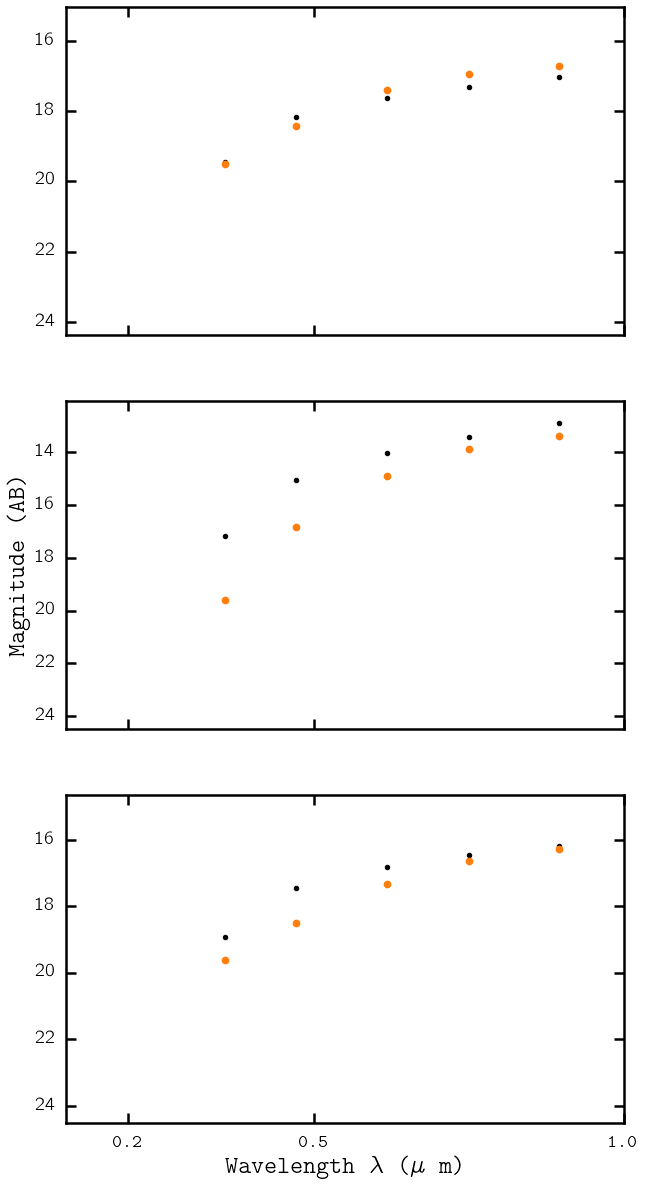

In [19]:
fig = plt.figure(figsize=(10,20))

for i_gal, gal_dict in enumerate([gal1, gal2, gal3]): 
    sub = fig.add_subplot(3,1,i_gal+1)
    
    photo = GalPhoto(gal_dict)
    sub.scatter(L_sdss, photo, c='k', lw=1)
    sub.scatter(L_sdss, -2.5*np.log10(gal_dict['maggies'][1:-1]), lw=0, s=60, c=pretty_colors[3])

    sub.set_xlim([0.1, 1.])
    sub.set_ylim([1.25 * np.max(-2.5*np.log10(gal_dict['maggies'][1:-1])), 0.9 * np.min(-2.5* np.log10(gal_dict['maggies'][1:-1]))])
    sub.set_xticks([0.2, 0.5, 1.0])
    if i_gal == 2: 
        sub.set_xlabel('Wavelength $\lambda$ ($\mu$ m)', fontsize=25)
        sub.set_xticklabels([0.2, 0.5, 1.0])
    else: 
        sub.set_xticklabels('')
    if i_gal == 1: 
        sub.set_ylabel('Magnitude (AB)', fontsize=25)